In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16)

Wall time: 494 ms


In [5]:
%%time
train, val, test = data.get_splits(['skip'], [4])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 993 train | 595 val | 2381 test
Wall time: 134 ms


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', False],
 [',.._.._,_...,.,_', 'w.__,,_,,_,__..,', '..,_cr_.,.,_.___', False],
 ['..,._,.__.,__,,_', 'w,,_,..__,_,_,..', '_,._,__.cr._,___', False],
 ['_,,,,,._.,..,___', 'w.,_.,_,__,.,__,', '.,..,.__...,cr..', False],
 ['_.,,____._.,_,._', ',w._...._.,,_,_.', '_cr____,._.,,,_.', False],
 [',__,.__._,.__,..', '.w,,.,.,.,._,_,.', ',..._cr,,.,..,_,', False],
 ['_,_,..,,_,___...', '.w_.._.,,.,,..,_', '_,..__._,cr.___,', False],
 ['_.,_,.,.,._,__._', '_w,,,,,_.,..,,,,', '.,,,,__..,_,_cr,', False],
 [',,_...___.,,,,_.', '..w,,,,,_.._.,_.', ',_cr.,__,._,_,._', False],
 ['._,_,_...__,,,_,', '..w,._.___._,..,', ',__.,.cr,_.,,._.', False],
 [',_.._._,,..,.,.,', ',_w,,,..___,__.,', '____.,,,_.cr___,', False],
 ['__.,__,_.._,,.__', '..w.,.,._,._,,_,', '_,.,,_.,,.,_,,cr', False],
 [',.,.,,._,_,,,.,_', '__.w_,.,_,.,...,', '.,.cr_..,,.._._,', False],
 ['..,_..__,.,_....', ',_.w,,,.__,.__.,', '_,....,cr.,,._..', False],
 ['.,.,..,._._..__.'

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 56 | F2-uw 56 | F2-w 60 | F2-noop 63 | 
F3 cr:    F2-wu 57 | F2-uw 56 | F2-w 60 | F2-noop 64 | 
F3 r:    F2-wu 60 | F2-uw 60 | F2-w 64 | F2-noop 68 | 
F3 noop:    F2-wu 64 | F2-uw 64 | F2-w 68 | F2-noop 73 | 

Positive samples count: 431
Total samples count: 993
Positive class ratio: 0.4340382678751259


#### Peek at test data

In [8]:
test_original[:15]

[['_,,,.,,,,,,,.,,.', '.,___,,,_,..___,', ',._.,..._...cr..', False],
 ['_.._,,.,,,,,_...', ',,,____.,_,,.uw_', '__.._._,,____.__', False],
 [',__,.__.,,_,,._,', '._w,,_._.,.___.,', ',,_,_.,___,,_._.', False],
 ['.,.,_,__.,_,_.._', '.___,...,.,,_.,,', '____._.,dr.,.,._', True],
 ['._._.,,..,,_,..,', ',.._.__.,_,.__.w', '__,,.r,.,,__..,,', True],
 [',_...___.._,,,__', '.._uw_,_._,_.,_,', '_..._.,_....___,', False],
 ['.._,__,,_,,,,__,', '__,,,.___.,.,.._', '___,_.r,_,.,,__,', True],
 ['_,_.,__,_,_,__,.', '.._._.,,._.,.w..', '.,_..,,_,..._._,', False],
 ['___._,_,__..,._.', ',._,_.,,..wu..,.', '_.,_.,,,.r..,___', True],
 ['_.,._,_..__,....', '_.,.,.._.,__._wu', '_,___.__._..____', False],
 [',,.,_,__.,.__.,_', '...,__.,.__._..,', '_,_....,,.cr,__,', False],
 ['._..__,,,,,.,,_.', '.._._,.,__.,__,_', ',,___..,dr__..__', True],
 [',____.,,.,.._,._', '___uw,_,,,_.,.__', '__,dr_.._._,,._.', True],
 ['._._.._.__,..,,,', '_,_,_.,.__.w___.', '_,_,dr,__._.....', True],
 [',,_._,._,.._._,,', '.w_.

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 136 | F2-uw 138 | F2-w 151 | F2-noop 153 | 
F3 cr:    F2-wu 129 | F2-uw 146 | F2-w 150 | F2-noop 149 | 
F3 r:    F2-wu 136 | F2-uw 149 | F2-w 149 | F2-noop 166 | 
F3 noop:    F2-wu 148 | F2-uw 152 | F2-w 159 | F2-noop 170 | 

Positive samples count: 1042
Total samples count: 2381
Positive class ratio: 0.4376312473750525


#### Peek at val data

In [10]:
val_original[:15]

[['__._____...._,,_', ',__wu,.,__,,.,..', 'cr_,,.__.,.__,,_', False],
 [',,_,.,_.,,,._,_.', ',_,..,.,,.,_,__.', 'cr_,.__,,...,___', False],
 ['__._._.__._,._,,', ',_,__,_,,_.._,,,', ',,,.,._,__,._cr.', False],
 ['_._,_._.,,..._,_', '...,,,,,_,,,_.,w', '__,,,.,,,_._.r_,', True],
 ['....,._,,,_.,.__', '._,__..,,_.,,._.', '.,.._._,__r.__.,', True],
 [',___,_.._,.._,..', ',...._,w.,,.,,._', '_.._.___,__.,_r.', True],
 [',.,_,..,.__.__.,', ',,,,,,,uw_.,_...', ',.._..,,_.,,r...', True],
 ['..__,.,.__.,_,_,', 'wu_,,.._,_.___,_', '.,,____.,..,,_dr', False],
 ['_._._..,._,.,..,', '.._.._wu..__.__.', '__.,__,,,r_____,', True],
 ['__.._,_,__,.,__,', ',.,,,.,.._uw_._,', '.,,..__._,_r.__,', True],
 [',_,._.,.__.,,,_.', '_,.uw,_._....._,', '__._..,___,,,.,,', False],
 ['.,..,._,,,,.,_,.', ',..,wu.__,._._._', '___.r.__,,.,_,..', True],
 ['.._,_,_,.,._,.__', ',.._.,,.,.,._,,w', '..,__,cr.,,___,,', False],
 ['_,,._...,_,,.,_.', '_,,,,_wu.,_,..__', '.._,_.,....__cr_', False],
 ['.__,.._.,.,,_,_.', ',.._

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 33 | F2-uw 31 | F2-w 29 | F2-noop 39 | 
F3 cr:    F2-wu 39 | F2-uw 23 | F2-w 30 | F2-noop 42 | 
F3 r:    F2-wu 44 | F2-uw 31 | F2-w 43 | F2-noop 38 | 
F3 noop:    F2-wu 43 | F2-uw 39 | F2-w 45 | F2-noop 46 | 

Positive samples count: 255
Total samples count: 595
Positive class ratio: 0.42857142857142855


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([993, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([993, 128])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([993, 16, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "skip_4"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_{experiment_name}')    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_{experiment_name}'))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1s.append(get_f1(precisions[-1], recalls[-1]))
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_{experiment_name}')    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1s[-1]['Overall'])
    return accuracies, precisions, recalls, f1s, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recalls, cnn_f1s, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

1 / 20 models trained | Current model test accuracy: 0.9953800923981521
2 / 20 models trained | Current model test accuracy: 0.9903401931961361
3 / 20 models trained | Current model test accuracy: 0.9806803863922722
4 / 20 models trained | Current model test accuracy: 0.994960100797984
5 / 20 models trained | Current model test accuracy: 0.994540109197816
6 / 20 models trained | Current model test accuracy: 0.9882402351952961
7 / 20 models trained | Current model test accuracy: 0.9815203695926081
8 / 20 models trained | Current model test accuracy: 0.9840403191936161
9 / 20 models trained | Current model test accuracy: 0.994960100797984
10 / 20 models trained | Current model test accuracy: 0.9836203275934481
11 / 20 models trained | Current model test accuracy: 0.994960100797984
12 / 20 models trained | Current model test accuracy: 0.9907601847963041
13 / 20 models trained | Current model test accuracy: 0.994540109197816
14 / 20 models trained | Current model test accuracy: 0.989500209

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recalls, lstm_f1s, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | Current model test accuracy: 1.0
2 / 20 models trained | Current model test accuracy: 1.0
3 / 20 models trained | Current model test accuracy: 0.999160016799664
4 / 20 models trained | Current model test accuracy: 1.0
5 / 20 models trained | Current model test accuracy: 0.999160016799664
6 / 20 models trained | Current model test accuracy: 0.999580008399832
7 / 20 models trained | Current model test accuracy: 0.997060058798824
8 / 20 models trained | Current model test accuracy: 1.0
9 / 20 models trained | Current model test accuracy: 0.9428811423771525
10 / 20 models trained | Current model test accuracy: 1.0
11 / 20 models trained | Current model test accuracy: 0.998740025199496
12 / 20 models trained | Current model test accuracy: 1.0
13 / 20 models trained | Current model test accuracy: 0.999580008399832
14 / 20 models trained | Current model test accuracy: 1.0
15 / 20 models trained | Current model test accuracy: 0.999580008399832
16 / 20 models trained | C

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recalls, deepset_f1s, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model test accuracy: 0.8366232675346493
2 / 20 models trained | Current model test accuracy: 0.8471230575388492
3 / 20 models trained | Current model test accuracy: 0.8336833263334733
4 / 20 models trained | Current model test accuracy: 0.8353632927341453
5 / 20 models trained | Current model test accuracy: 0.8261234775304493
6 / 20 models trained | Current model test accuracy: 0.8177236455270894
7 / 20 models trained | Current model test accuracy: 0.8374632507349853
8 / 20 models trained | Current model test accuracy: 0.8383032339353212
9 / 20 models trained | Current model test accuracy: 0.8391432171356573
10 / 20 models trained | Current model test accuracy: 0.8366232675346493
11 / 20 models trained | Current model test accuracy: 0.8467030659386813
12 / 20 models trained | Current model test accuracy: 0.8362032759344813
13 / 20 models trained | Current model test accuracy: 0.8320033599328014
14 / 20 models trained | Current model test accuracy: 0.8458

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recalls, deepsetv2_f1s, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | Current model test accuracy: 0.4376312473750525
2 / 20 models trained | Current model test accuracy: 0.4376312473750525
3 / 20 models trained | Current model test accuracy: 0.4376312473750525
4 / 20 models trained | Current model test accuracy: 0.4376312473750525
5 / 20 models trained | Current model test accuracy: 0.4376312473750525
6 / 20 models trained | Current model test accuracy: 0.4376312473750525
7 / 20 models trained | Current model test accuracy: 0.4376312473750525
8 / 20 models trained | Current model test accuracy: 0.4376312473750525
9 / 20 models trained | Current model test accuracy: 0.4376312473750525
10 / 20 models trained | Current model test accuracy: 0.4376312473750525
11 / 20 models trained | Current model test accuracy: 0.4376312473750525
12 / 20 models trained | Current model test accuracy: 0.4376312473750525
13 / 20 models trained | Current model test accuracy: 0.4376312473750525
14 / 20 models trained | Current model test accuracy: 0.4376

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recalls, feedforward_f1s, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model test accuracy: 0.8328433431331373
2 / 20 models trained | Current model test accuracy: 0.8467030659386813
3 / 20 models trained | Current model test accuracy: 0.8412431751364973
4 / 20 models trained | Current model test accuracy: 0.8286434271314573
5 / 20 models trained | Current model test accuracy: 0.8488030239395212
6 / 20 models trained | Current model test accuracy: 0.8357832843343133
7 / 20 models trained | Current model test accuracy: 0.8412431751364973
8 / 20 models trained | Current model test accuracy: 0.8269634607307854
9 / 20 models trained | Current model test accuracy: 0.8282234355312894
10 / 20 models trained | Current model test accuracy: 0.8349433011339773
11 / 20 models trained | Current model test accuracy: 0.8349433011339773
12 / 20 models trained | Current model test accuracy: 0.8336833263334733
13 / 20 models trained | Current model test accuracy: 0.8412431751364973
14 / 20 models trained | Current model test accuracy: 0.8399

# Evaluation

### Get best 50% performing models

In [26]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [27]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [28]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,99.1%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.9%,100.0%,100.0%,100.0%,100.0%,99.6%,99.3%,99.7%,85.0%
LSTM,99.7%,100.0%,100.0%,100.0%,100.0%,100.0%,99.9%,100.0%,94.6%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.6%
DeepSet(like in paper),83.6%,99.7%,99.6%,99.5%,99.7%,93.1%,90.3%,93.1%,11.1%,98.6%,98.3%,98.7%,98.8%,61.2%,65.6%,61.6%,62.6%
DeepSet(sum at start),43.8%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,83.7%,99.6%,99.3%,98.9%,99.7%,93.8%,90.8%,92.9%,9.6%,97.6%,97.7%,97.8%,99.1%,63.5%,66.1%,63.3%,62.8%
Sample count,2381,149,146,150,129,153,138,151,136,170,152,159,148,166,149,149,136


## Accuracy breakdown by cases for top 50% of models

In [29]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [30]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,99.5%,100.0%,100.0%,100.0%,97.9%
LSTM,100.0%,100.0%,100.0%,100.0%,100.0%
DeepSet(like in paper),84.1%,99.8%,74.2%,99.4%,62.6%
DeepSet(sum at start),43.8%,0.0%,76.5%,0.0%,100.0%
Feedforward,84.2%,99.2%,74.3%,97.8%,65.3%
Sample count,2381,574,578,629,600


In [31]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [32]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,99.5%,100.0%,100.0%,100.0%,99.9%,100.0%,100.0%,97.9%
LSTM,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%
DeepSet(like in paper),84.1%,94.4%,91.5%,94.0%,11.9%,99.8%,99.4%,62.6%
DeepSet(sum at start),43.8%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,84.2%,95.6%,92.4%,94.0%,9.9%,99.2%,97.8%,65.3%
Sample count,2381,153,138,151,136,574,629,600


## Accuracies per CNN model

In [33]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,99.5%,100.0%,100.0%,100.0%,98.2%
CNN #1,99.0%,100.0%,100.0%,100.0%,96.2%
CNN #2,98.1%,100.0%,100.0%,100.0%,92.3%
CNN #3,99.5%,100.0%,100.0%,100.0%,98.0%
CNN #4,99.5%,100.0%,100.0%,100.0%,97.8%
CNN #5,98.8%,100.0%,100.0%,100.0%,95.3%
CNN #6,98.2%,100.0%,100.0%,100.0%,92.7%
CNN #7,98.4%,100.0%,100.0%,100.0%,93.7%
CNN #8,99.5%,100.0%,100.0%,100.0%,98.0%
CNN #9,98.4%,100.0%,100.0%,100.0%,93.5%


## Accuracies per LSTM model

In [34]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #1,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #2,99.9%,100.0%,100.0%,100.0%,99.7%
LSTM #3,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #4,99.9%,100.0%,99.7%,100.0%,100.0%
LSTM #5,100.0%,100.0%,99.8%,100.0%,100.0%
LSTM #6,99.7%,100.0%,98.8%,100.0%,100.0%
LSTM #7,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #8,94.3%,100.0%,76.5%,100.0%,100.0%
LSTM #9,100.0%,100.0%,100.0%,100.0%,100.0%


## Accuracies per DeepSets V1 model

In [35]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,83.7%,99.8%,73.9%,99.5%,61.0%
DeepSet(like in paper) #1,84.7%,100.0%,75.1%,100.0%,63.3%
DeepSet(like in paper) #2,83.4%,100.0%,72.0%,99.4%,61.7%
DeepSet(like in paper) #3,83.5%,98.8%,73.9%,96.5%,64.7%
DeepSet(like in paper) #4,82.6%,100.0%,68.2%,99.0%,62.7%
DeepSet(like in paper) #5,81.8%,100.0%,69.9%,99.0%,57.7%
DeepSet(like in paper) #6,83.7%,99.8%,75.4%,100.0%,59.3%
DeepSet(like in paper) #7,83.8%,99.7%,72.1%,98.3%,64.8%
DeepSet(like in paper) #8,83.9%,99.5%,73.2%,99.7%,62.8%
DeepSet(like in paper) #9,83.7%,99.1%,74.0%,98.4%,62.7%


## Accuracies per DeepSets V2 model

In [36]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #1,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #2,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #3,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #4,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #5,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #6,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #7,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #8,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #9,43.8%,0.0%,76.5%,0.0%,100.0%


## Accuracies per FeedForward model

In [37]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,83.3%,100.0%,70.6%,99.0%,63.0%
Feedforward #1,84.7%,99.8%,74.6%,99.7%,64.2%
Feedforward #2,84.1%,99.3%,73.9%,97.0%,66.0%
Feedforward #3,82.9%,99.5%,68.2%,99.8%,63.3%
Feedforward #4,84.9%,99.5%,73.4%,98.1%,68.2%
Feedforward #5,83.6%,99.1%,73.4%,99.8%,61.5%
Feedforward #6,84.1%,98.6%,73.7%,98.1%,65.7%
Feedforward #7,82.7%,98.4%,72.8%,95.7%,63.5%
Feedforward #8,82.8%,99.5%,73.0%,99.0%,59.3%
Feedforward #9,83.5%,99.5%,70.6%,98.3%,65.2%


# Training evolution

### CNN

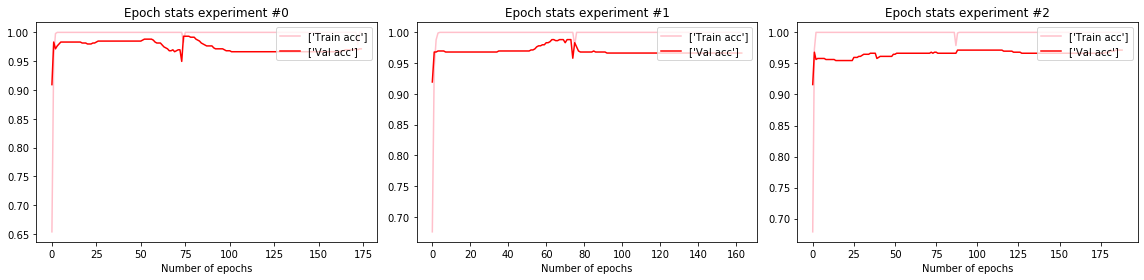

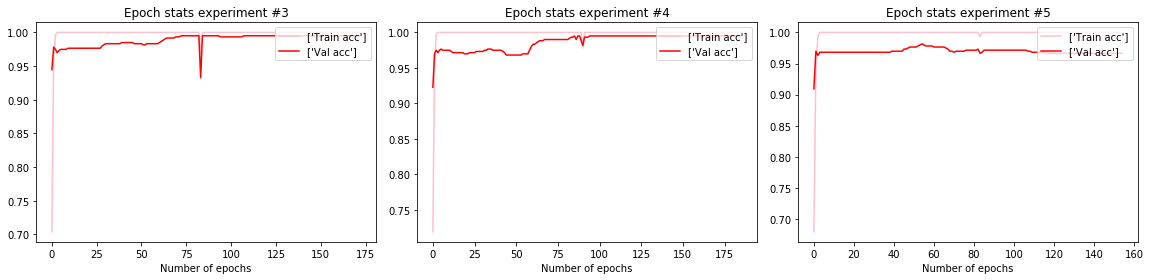

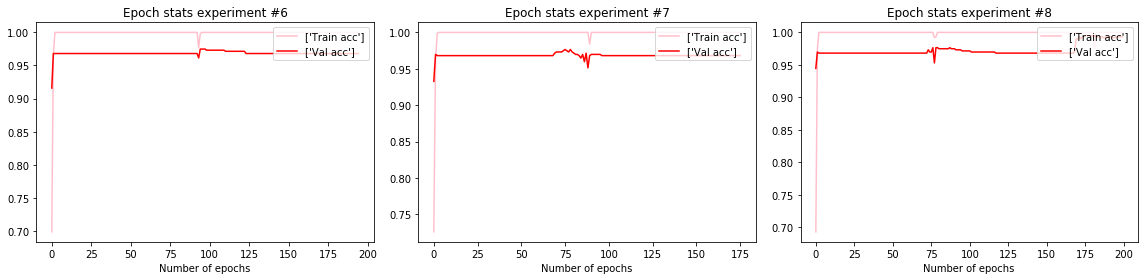

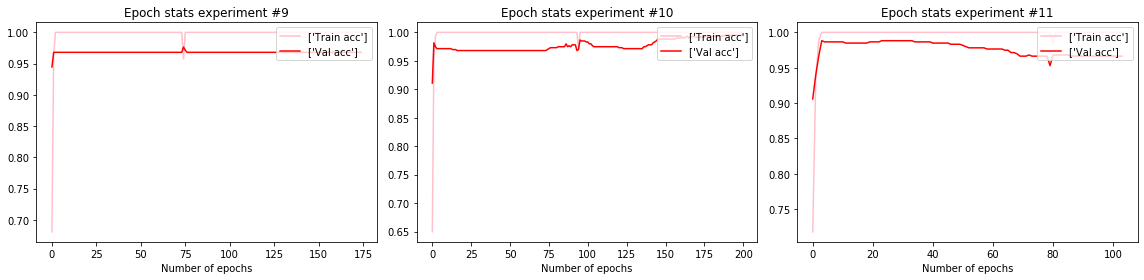

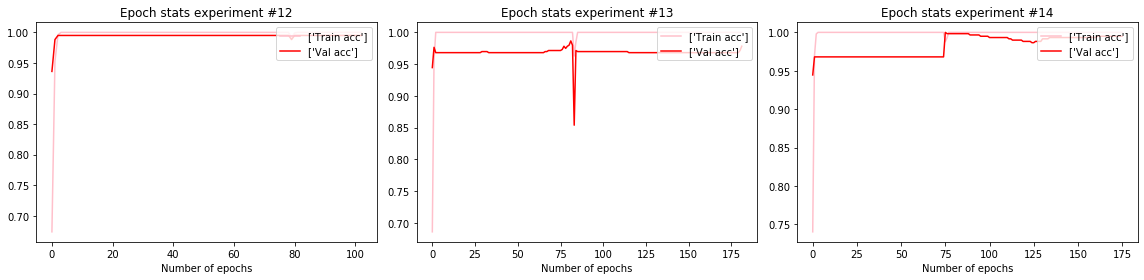

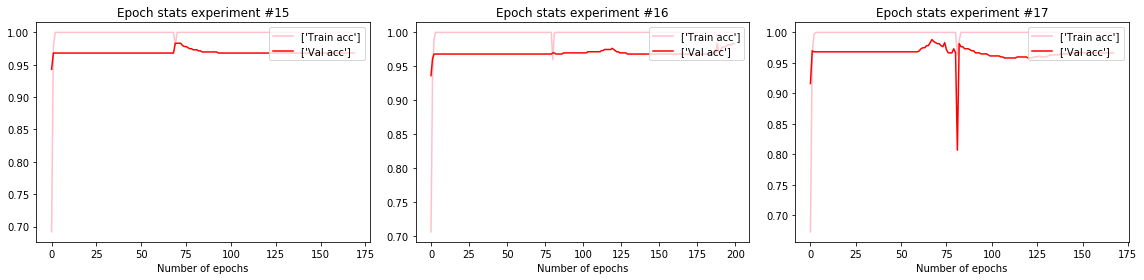

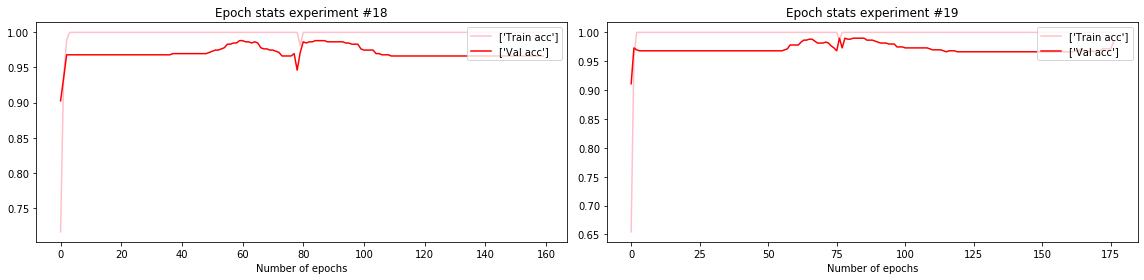

In [38]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

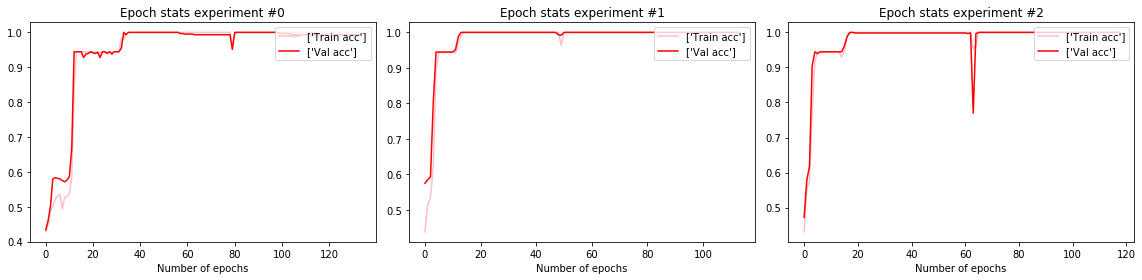

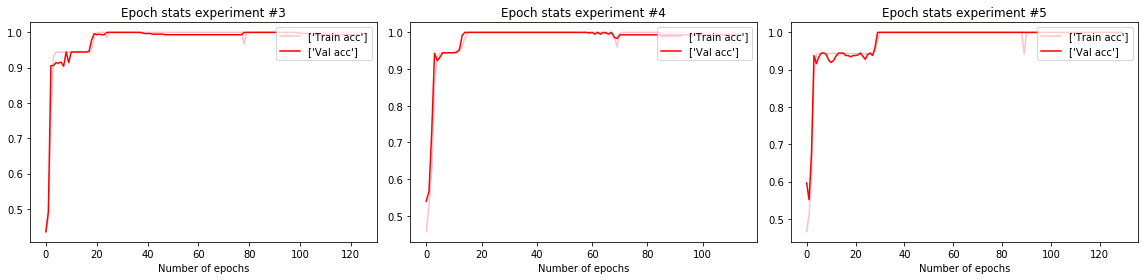

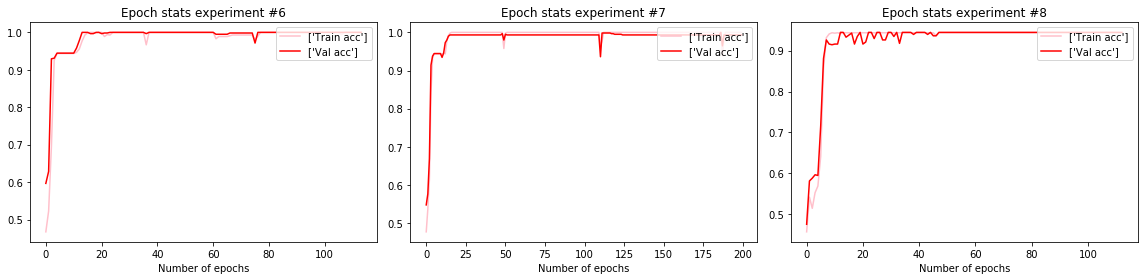

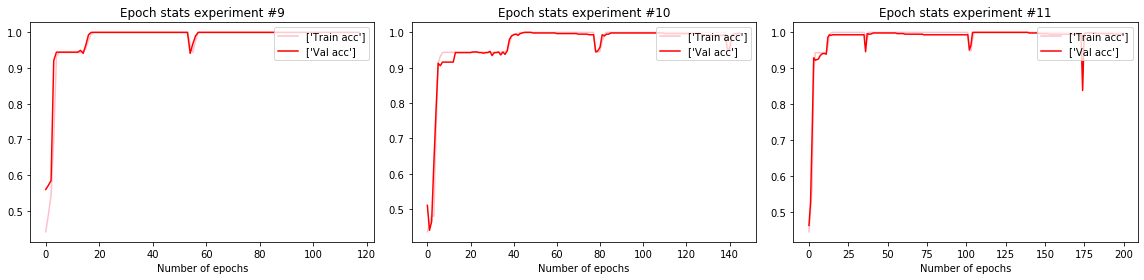

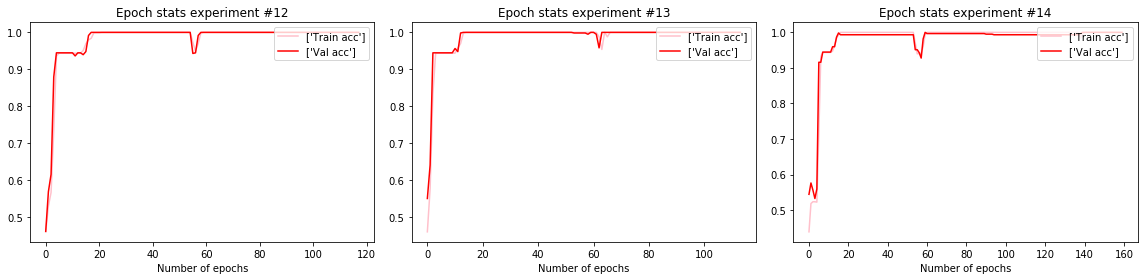

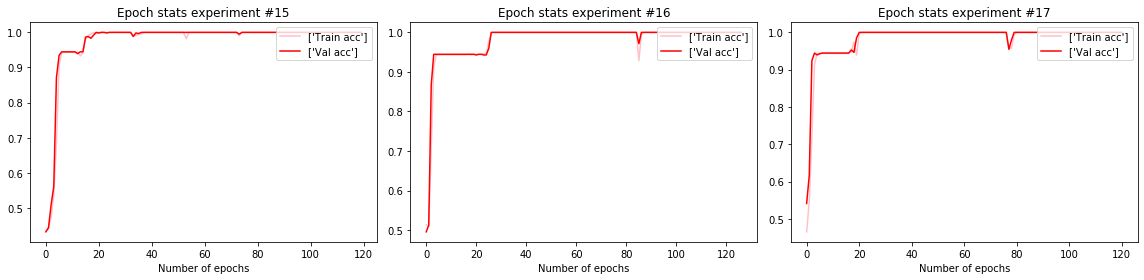

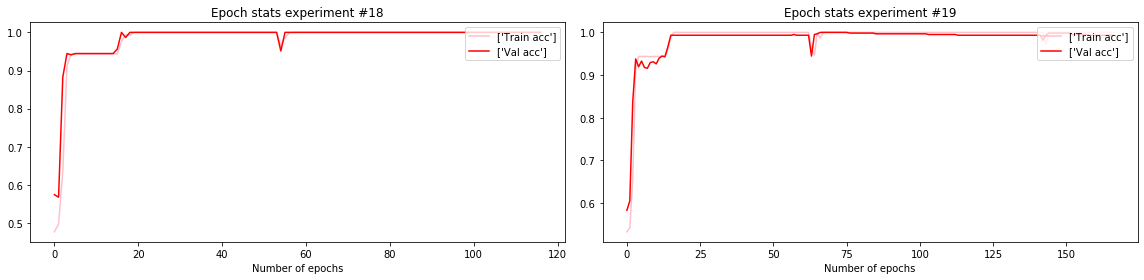

In [39]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

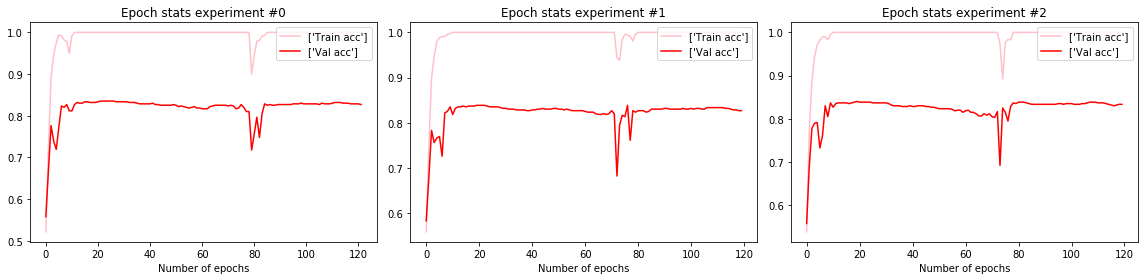

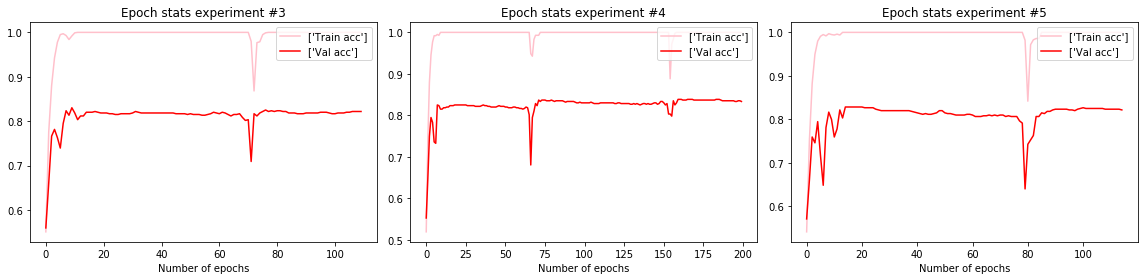

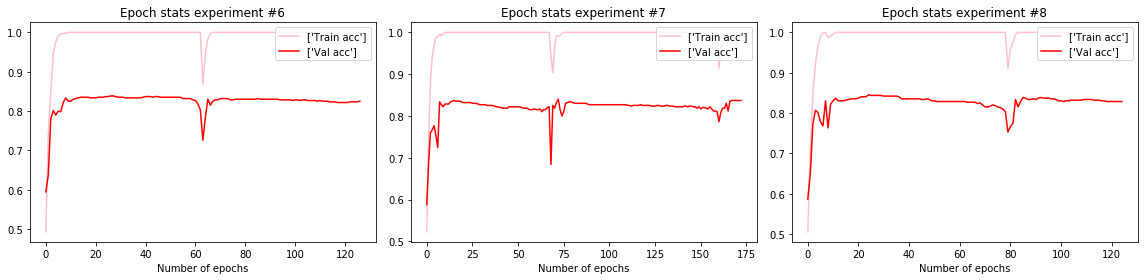

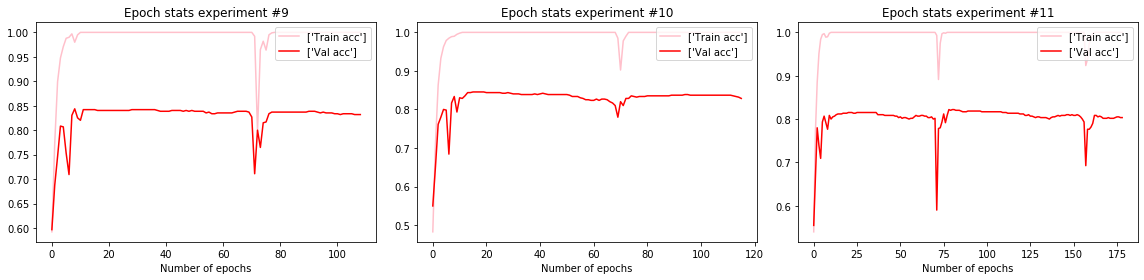

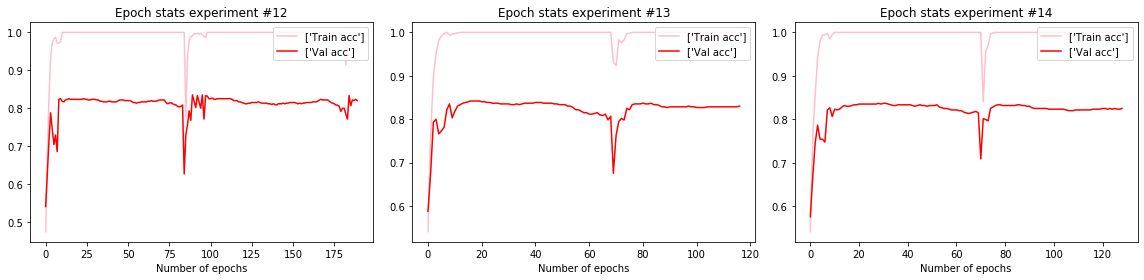

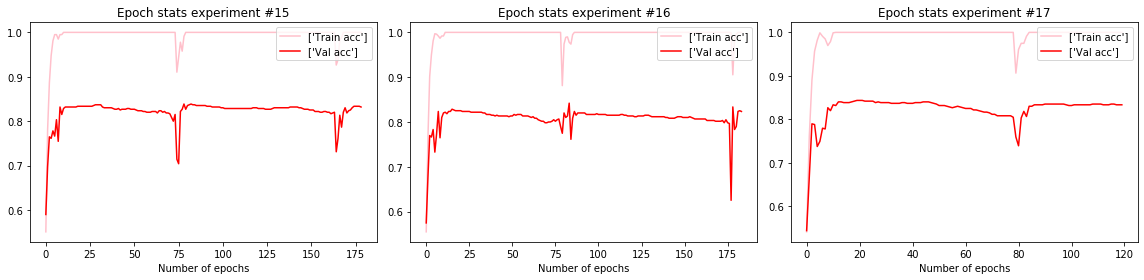

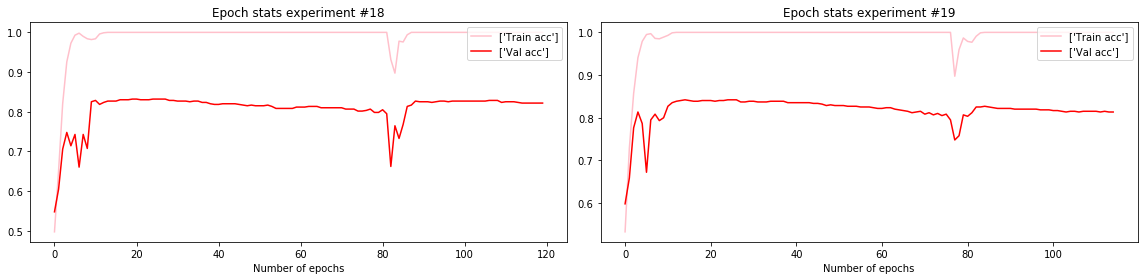

In [40]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

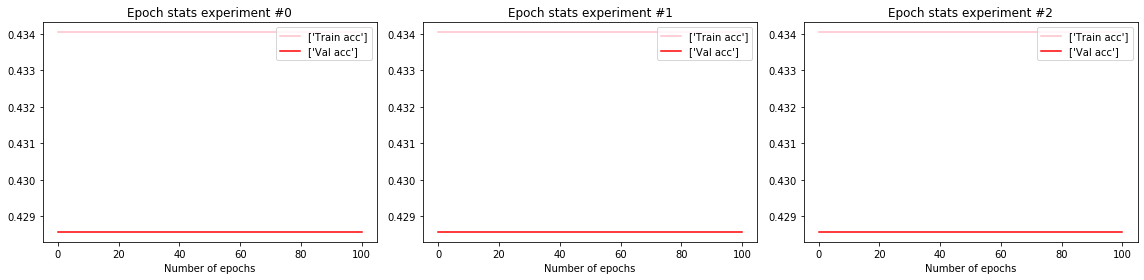

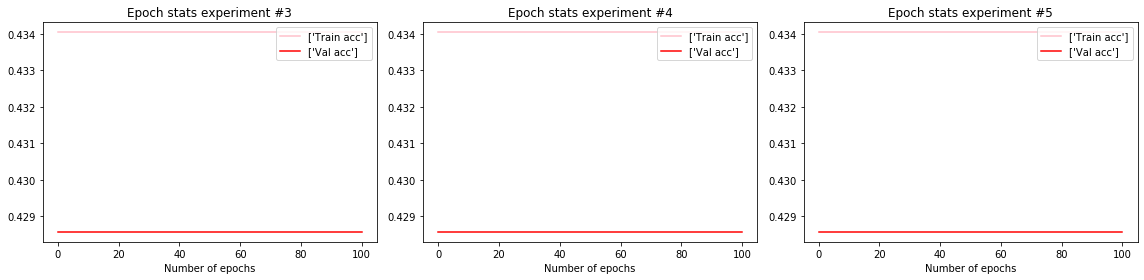

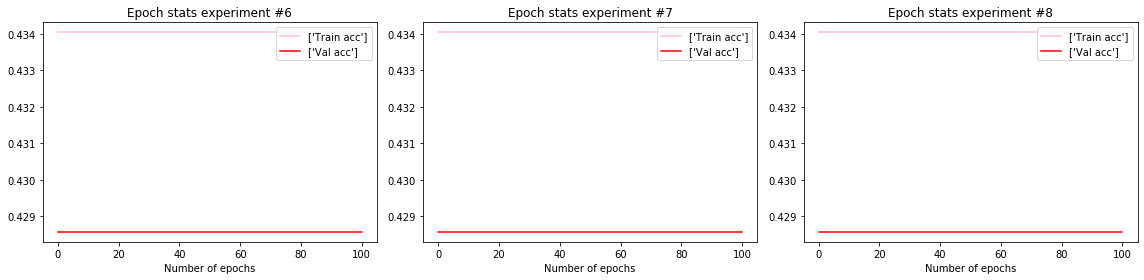

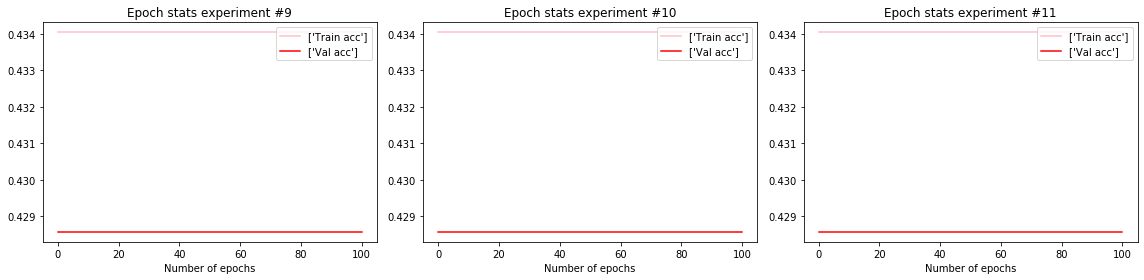

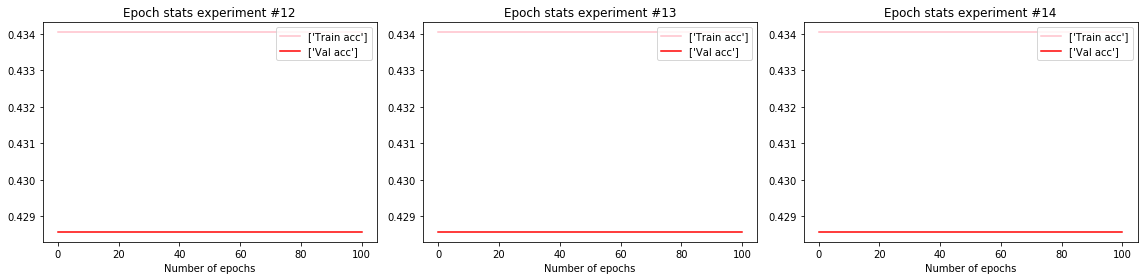

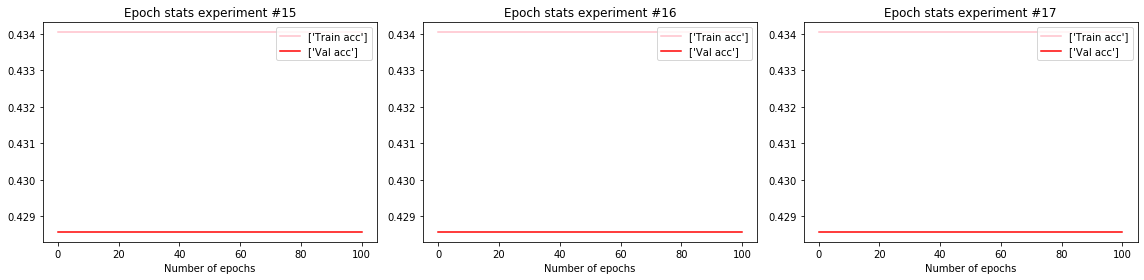

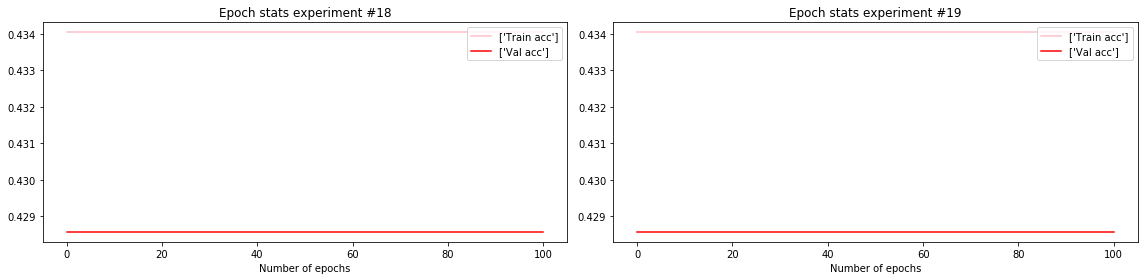

In [41]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

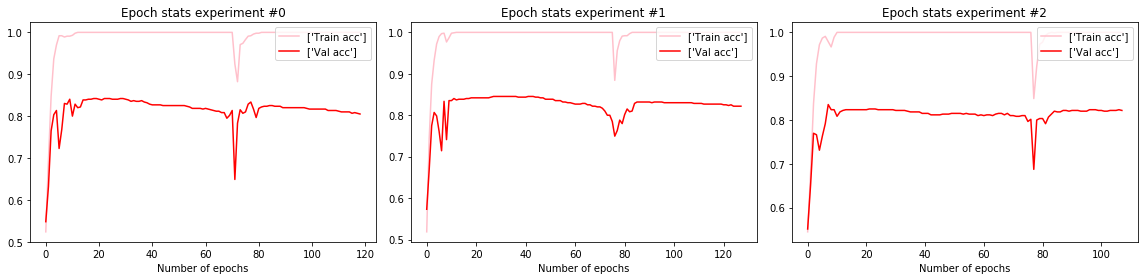

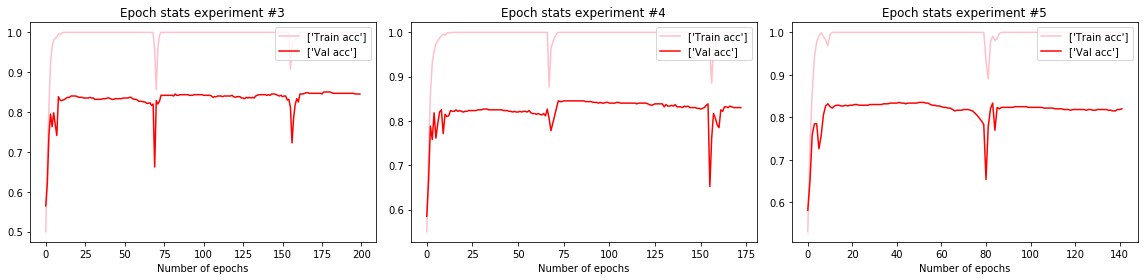

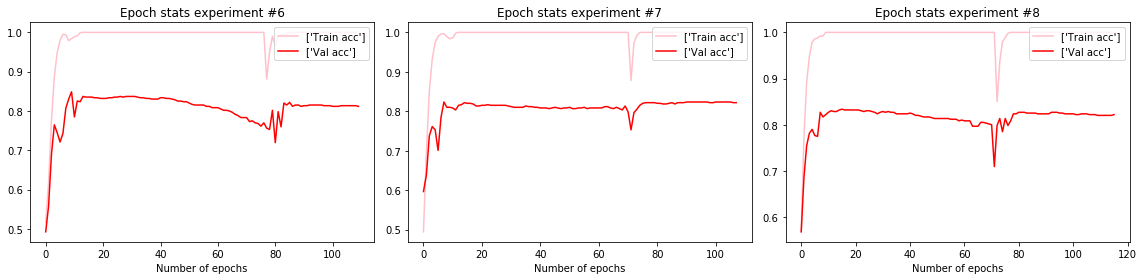

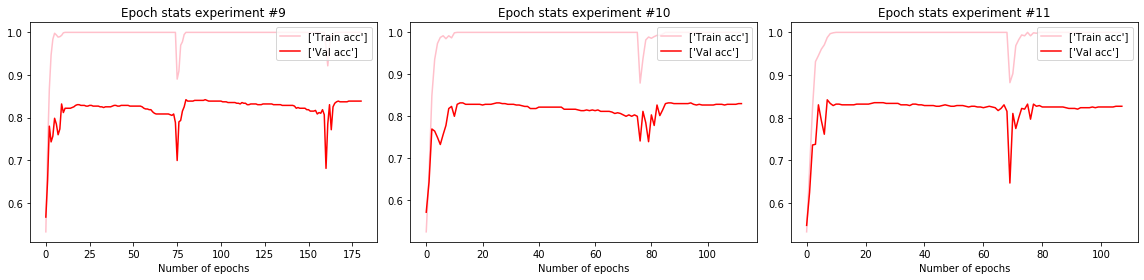

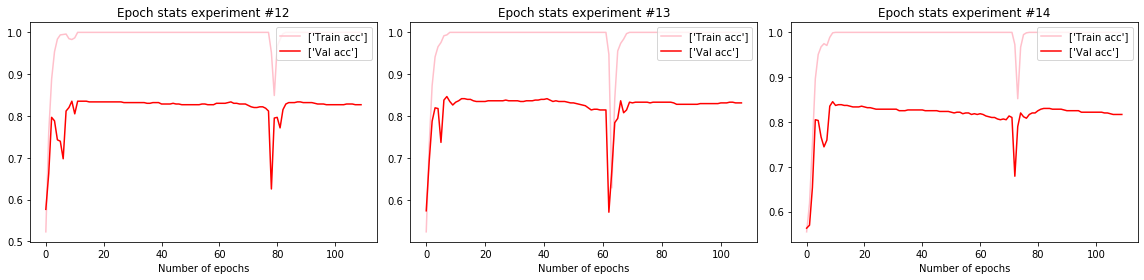

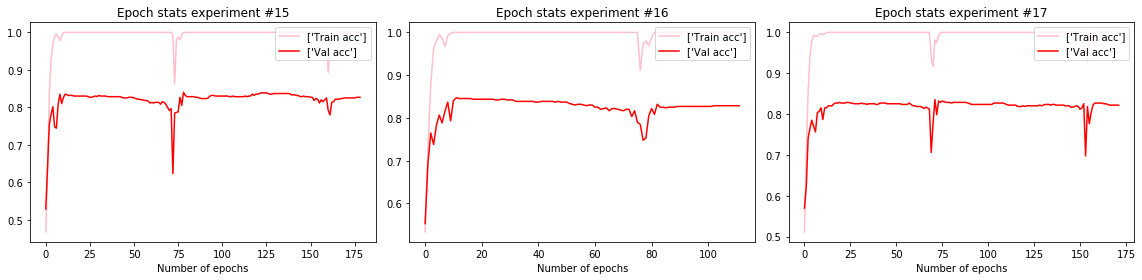

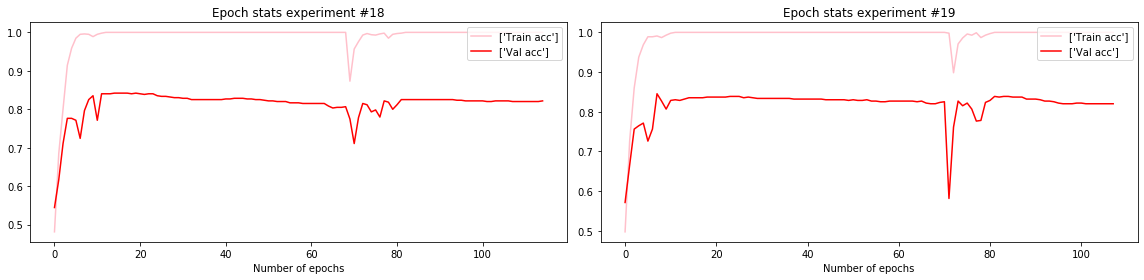

In [42]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [43]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_' + experiment_name))

<All keys matched successfully>

In [ ]:
get_summary_df(["CNN", "LSTM", "DEEPSET", "DEEPSETv2", "FEEDFORWARD"], [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies], [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions], [cnn_recalls, lstm_recalls, deepset_recalls, deepsetv2_recalls, feedforward_recalls], [cnn_f1s, lstm_f1s, deepset_f1s, deepsetv2_f1s, feedforward_f1s])

## Top wrong predictions for best performing CNN model

In [44]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 





## Top wrong predictions for best performing LSTM model

In [45]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 





## Top wrong predictions for best performing DeepSets V1 model

In [46]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,.,wu.,.,__.,,_. dr.._.._.,_.,_,_ | label: False | actual prediction: 0.9999853372573853
_____wu_,.,,_.., .___,,,dr.,__,,. | label: False | actual prediction: 0.9999674558639526
_,wu_...,____.,_ _,,dr,,.,,__..__ | label: False | actual prediction: 0.9999653100967407
___.__,,._wu__,_ ._,,_._dr___,,,. | label: False | actual prediction: 0.9999492168426514
,..wu_,.,,.,_,., _,.__,__dr,._.__ | label: False | actual prediction: 0.9999396800994873
.___,..wu___..,_ ._,dr__,__,.,,,_ | label: False | actual prediction: 0.9998953342437744
.,,wu,_,__,.,,,_ ...,...__dr.._,, | label: False | actual prediction: 0.9998594522476196
_...,,_.,,_wu... ___dr_,.._...._. | label: False | actual prediction: 0.999853253364563
._._.,wu_...,_,_ ,,_dr,_.,..,_,,, | label: False | actual prediction: 0.9998376369476318
,,...,,._wu.,... ,_._.,._,.dr.,_, | label: False | actual prediction: 0.9998254179954529

Top 10 false negatives: 

__,....,,.wu.__. ,__..,.,._.r._., | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [47]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

,._,_.,,..wu..,. _.,_.,,,.r..,___ | label: True | actual prediction: 0.5
.._._,.,__.,__,_ ,,___..,dr__..__ | label: True | actual prediction: 0.5
___uw,_,,,_.,.__ __,dr_.._._,,._. | label: True | actual prediction: 0.5
_,_,_.,.__.w___. _,_,dr,__._..... | label: True | actual prediction: 0.5
.,,,,_.,,,_.,,., __,dr..,.._,,._, | label: True | actual prediction: 0.5
_..w._,,,,.__,,, _,_,..,r_,.,_.__ | label: True | actual prediction: 0.5
___,_w_____,._., _,,,_.,__,,,_r., | label: True | actual prediction: 0.5
,,,....,.__.,.._ _._,.,dr.,._.._, | label: True | actual prediction: 0.5
_,,,.__,,uw.,.., ,,__.._..,,r_,.. | label: True | actual prediction: 0.5
__.__._,,_..,_., ._.,__,._,_..r_. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [48]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,_,._.,__wu.,_,. ,,.._...._,_.dr. | label: False | actual prediction: 0.9999909400939941
,,_,._,_.,.wu.,_ __,_._.,,..dr.._ | label: False | actual prediction: 0.9999728202819824
___.__,,._wu__,_ ._,,_._dr___,,,. | label: False | actual prediction: 0.9998979568481445
,,._._._..._.wu_ ,,,,,_...dr.,._, | label: False | actual prediction: 0.9998863935470581
__,,_wu.__,...,_ ,__.,.__,_..,_dr | label: False | actual prediction: 0.9998624324798584
wu_,,.,_,,__._., dr.,_,._._.,..,_ | label: False | actual prediction: 0.9998353719711304
.....,__.,_,_,wu ,.,.___,__dr.,,. | label: False | actual prediction: 0.9998161196708679
_wu,_,_,_.,,,.._ _.,._,_,,.dr.,,. | label: False | actual prediction: 0.9997697472572327
.,wu,.,__...._._ .__,.._,dr..,__, | label: False | actual prediction: 0.9997668862342834
.,_.,_,wu__,.___ dr_,.__,_,._,,_. | label: False | actual prediction: 0.9997345805168152

Top 10 false negatives: 

._,_._._._,,,wu. _,.r,,.._.,.,,_, | label: True | actual 

# Saving Notebook State

In [49]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [50]:
import dill
experiment_name = "skip_4"
# dill.load_session('notebook_env_' + experiment_name + '.db')